In [1]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [2]:
lung_seg_path = os.path.join("..", "data", "processed","Lung Segmentation Data")

In [3]:
def load_images(folder_path, num_images, final_folder):
    '''Cette fonction permet de charger les images qui seront utilisées pour le modèle LeNet.
    folder_path est le chemin vers le dossier contenant l'ensemble des images (qui contient normalement 3 sous-dossiers)
    num_images est le nombre d'images que l'on souhaite importer par sous dossier
    final_folder est le dossier final dans lequel les images sont contenues : "images" pour les données brutes, "lung_masks" pour les masques...'''

    images = []
    labels = []

    for subfolder in os.listdir(folder_path): # Je parcours les sous-dossiers (Covid, Non-covid, Normal)
        subfolder_path = os.path.join(folder_path, subfolder, final_folder) # Les images se situent encore dans un sous dossier

        for image in tqdm(os.listdir(subfolder_path)[:num_images]):
            image_path = os.path.join(subfolder_path, image)
            img = cv2.imread(image_path,  cv2.IMREAD_GRAYSCALE)
            img_array = np.array(img)
            images.append(img_array)
            labels.append(subfolder)
    
    return images, labels

In [4]:
image, label = load_images(lung_seg_path, 1000, "images") # Images brutes

100%|██████████| 1000/1000 [00:01<00:00, 797.45it/s]


In [5]:
image_norm, label_norm = load_images(lung_seg_path, 1000, "MinMaxNormalized images")

100%|██████████| 1000/1000 [00:09<00:00, 109.41it/s]


In [6]:
image_norm_hist, label_norm_hist = load_images(lung_seg_path, 1000, "HistEgalNormalized images")

100%|██████████| 1000/1000 [00:05<00:00, 169.13it/s]


In [7]:
# Transformation des labels pour ne plus avoir des strings
label_encoder = LabelEncoder()
targets_encoded = label_encoder.fit_transform(label) #COVID-19 =0, Non_COVID =1, Normal =2
targets_encoded.shape

(3000,)

In [8]:
# Transformation des labels pour ne plus avoir des strings (Images normalisées MinMax)
label_encoder_norm = LabelEncoder()
targets_encoded_norm = label_encoder_norm.fit_transform(label_norm) #COVID-19 =0, Non_COVID =1, Normal =2
targets_encoded_norm.shape

(3000,)

In [9]:
# Transformation des labels pour ne plus avoir des strings (Images normalisées HistEgal)
label_encoder_norm_hist = LabelEncoder()
targets_encoded_norm_hist = label_encoder_norm_hist.fit_transform(label_norm_hist) #COVID-19 =0, Non_COVID =1, Normal =2
targets_encoded_norm_hist.shape

(3000,)

In [10]:
# Transformation de la liste d'images en tableau à 4 dimensions (nb_images, largeur, hauteur, profondeur)
images_encoded = np.stack(image)
images_encoded = images_encoded.reshape((-1, 256, 256, 1))
images_encoded.shape

(3000, 256, 256, 1)

In [11]:
# Transformation de la liste d'images en tableau à 4 dimensions (nb_images, largeur, hauteur, profondeur) (Images normalisées)
images_encoded_norm = np.stack(image_norm)
images_encoded_norm = images_encoded_norm.reshape((-1, 256, 256, 1))
images_encoded_norm.shape

(3000, 256, 256, 1)

In [12]:
# Transformation de la liste d'images en tableau à 4 dimensions (nb_images, largeur, hauteur, profondeur) (Images normalisées HistEgal)
images_encoded_norm_hist = np.stack(image_norm_hist)
images_encoded_norm_hist = images_encoded_norm_hist.reshape((-1, 256, 256, 1))
images_encoded_norm_hist.shape

(3000, 256, 256, 1)

In [13]:
# Séparation des données en ensembles de test et train
X_train, X_test, y_train, y_test = train_test_split(images_encoded, targets_encoded, test_size=0.2, random_state=42)

# Séparation des données en ensembles de test et train (Images normalisées)
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(images_encoded_norm, targets_encoded_norm, test_size=0.2, random_state=42)

# Séparation des données en ensembles de test et train (Images normalisées HistEgal)
X_norm_hist_train, X_norm_hist_test, y_norm_hist_train, y_norm_hist_test = train_test_split(images_encoded_norm_hist, targets_encoded_norm_hist, test_size=0.2, random_state=42)

In [14]:
from keras.utils import to_categorical

In [15]:
# Labels en vecteurs catégoriels binaires
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# Données de X comprises entre 0 et 1
X_train = X_train / 255
X_test = X_test / 255

# Labels en vecteurs catégoriels binaires (Images normalisées)
y_norm_train = to_categorical(y_norm_train)
y_norm_test = to_categorical(y_norm_test)

# Données de X comprises entre 0 et 1 (Images normalisées)
X_norm_train = X_norm_train / 255
X_norm_test = X_norm_test / 255

# Labels en vecteurs catégoriels binaires (Images normalisées HistEgal)
y_norm_hist_train = to_categorical(y_norm_hist_train)
y_norm_hist_test = to_categorical(y_norm_hist_test)

# Données de X comprises entre 0 et 1 (Images normalisées HistEgal)
X_norm_hist_train = X_norm_hist_train / 255
X_norm_hist_test = X_norm_hist_test / 255

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

In [17]:
# Architecture du modèle
inputs=Input(shape = (256, 256,1), name = "Input")


conv_1 = Conv2D(filters = 30,                    # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation

max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')

max_pool_2 = MaxPooling2D(pool_size = (2, 2))

flatten = Flatten()

dropout = Dropout(rate = 0.2)

dense_1 = Dense(units = 128,
                activation = 'relu')

dense_2 = Dense(units = 3,
                activation = 'softmax')
x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)


x=dropout(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)

d:\Nico\Code\MAR24_BDS_Radios_Pulmonaire\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
lenet = Model(inputs = inputs, outputs = outputs) # Images brutes

# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

training_history_lenet = lenet.fit(X_train, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.3730 - loss: 2.4537 - val_accuracy: 0.4521 - val_loss: 1.0532
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5852 - loss: 0.9893 - val_accuracy: 0.6833 - val_loss: 0.6602
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7270 - loss: 0.6451 - val_accuracy: 0.7833 - val_loss: 0.5211
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7883 - loss: 0.5518 - val_accuracy: 0.7937 - val_loss: 0.5042
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8486 - loss: 0.4477 - val_accuracy: 0.7917 - val_loss: 0.5045
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8364 - loss: 0.4579 - val_accuracy: 0.8104 - val_loss: 0.4614
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8313 - loss: 0.4508 - val_accuracy: 0.7812 - val_loss: 0.5640
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8331 - loss: 0.4633 - val_accuracy: 0.8313 - val_loss:

In [19]:
all_val_accuracy=[]
train_acc_lenet = training_history_lenet.history['accuracy']
all_val_accuracy.append(training_history_lenet.history['val_accuracy'])


# Results
test_pred_lenet = lenet.predict(X_test)
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_lenet_class))
pd.crosstab(y_test_class, test_pred_lenet_class)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
              precision    recall  f1-score   support

           0       0.88      0.69      0.78       217
           1       0.89      0.90      0.90       197
           2       0.72      0.90      0.80       186

    accuracy                           0.82       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.84      0.82      0.82       600



col_0,0,1,2
row_0,,,
0,150,18,49
1,4,178,15
2,16,3,167


In [20]:
lenet_norm = Model(inputs = inputs, outputs = outputs) # Images normalisées MinMax

# Compilation
lenet_norm.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

training_history_lenet_norm = lenet_norm.fit(X_norm_train, y_norm_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8696 - loss: 0.3220 - val_accuracy: 0.8479 - val_loss: 0.4222
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9464 - loss: 0.1475 - val_accuracy: 0.8521 - val_loss: 0.4106
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9595 - loss: 0.1142 - val_accuracy: 0.8500 - val_loss: 0.4327
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9699 - loss: 0.0997 - val_accuracy: 0.8479 - val_loss: 0.4542
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9744 - loss: 0.0796 - val_accuracy: 0.8562 - val_loss: 0.4376
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9870 - loss: 0.0579 - val_accuracy: 0.8521 - val_loss: 0.5186
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9919 - loss: 0.0389 - val_accuracy: 0.8479 - val_loss: 0.5115
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9940 - loss: 0.0305 - val_accuracy: 0.8438 - val_loss:

In [21]:
all_val_accuracy_norm=[]
train_acc_lenet_norm = training_history_lenet_norm.history['accuracy']
all_val_accuracy_norm.append(training_history_lenet_norm.history['val_accuracy'])


# Results
test_pred_lenet_norm = lenet_norm.predict(X_norm_test)
test_pred_lenet_class_norm = test_pred_lenet_norm.argmax(axis = 1)
y_test_class_norm = y_norm_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class_norm, test_pred_lenet_class_norm))
pd.crosstab(y_test_class_norm, test_pred_lenet_class_norm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       217
           1       0.91      0.90      0.91       197
           2       0.81      0.85      0.83       186

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



col_0,0,1,2
row_0,,,
0,179,12,26
1,8,178,11
2,23,5,158


In [22]:
lenet_norm_hist = Model(inputs = inputs, outputs = outputs) # Images normalisées MinMax

# Compilation
lenet_norm_hist.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

training_history_lenet_norm_hist = lenet_norm_hist.fit(X_norm_hist_train, y_norm_hist_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8784 - loss: 0.6044 - val_accuracy: 0.7896 - val_loss: 0.6129
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9079 - loss: 0.2276 - val_accuracy: 0.8500 - val_loss: 0.4951
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9698 - loss: 0.1375 - val_accuracy: 0.8625 - val_loss: 0.5145
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9804 - loss: 0.0673 - val_accuracy: 0.8646 - val_loss: 0.5780
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9909 - loss: 0.0414 - val_accuracy: 0.8667 - val_loss: 0.6028
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9942 - loss: 0.0319 - val_accuracy: 0.8396 - val_loss: 0.6392
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9938 - loss: 0.0304 - val_accuracy: 0.8708 - val_loss: 0.6667
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9981 - loss: 0.0171 - val_accuracy: 0.8667 - val_loss:

In [23]:
all_val_accuracy_norm_hist=[]
train_acc_lenet_norm_hist = training_history_lenet_norm_hist.history['accuracy']
all_val_accuracy_norm_hist.append(training_history_lenet_norm_hist.history['val_accuracy'])


# Results
test_pred_lenet_norm_hist = lenet_norm_hist.predict(X_norm_hist_test)
test_pred_lenet_class_norm_hist = test_pred_lenet_norm_hist.argmax(axis = 1)
y_test_class_norm_hist = y_norm_hist_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class_norm_hist, test_pred_lenet_class_norm_hist))
pd.crosstab(y_test_class_norm_hist, test_pred_lenet_class_norm_hist)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       217
           1       0.92      0.89      0.90       197
           2       0.83      0.80      0.81       186

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



col_0,0,1,2
row_0,,,
0,185,10,22
1,13,175,9
2,32,6,148


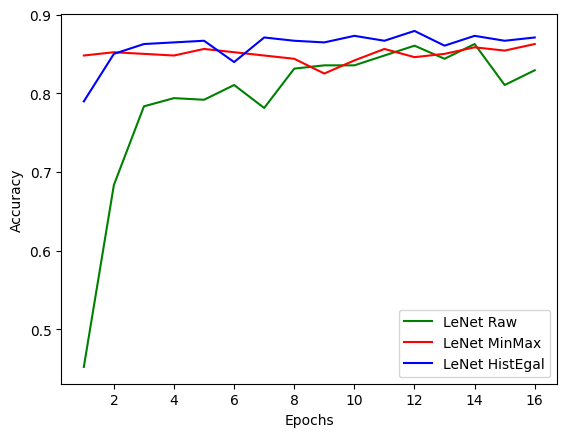

In [24]:
# Graphes combinés de l'ensemble des modèles
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[0], 
         label = 'LeNet Raw',
         color = 'green')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy_norm[0], 
         label = 'LeNet MinMax',
         color = 'red')        
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy_norm_hist[0], 
         label = 'LeNet HistEgal',
         color = 'blue')
plt.legend()